In [18]:
import pandas as pd
import numpy as np
from pathlib import Path
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Price Elasticity Analysis - Weekly Data with Sliding Window Validation

## Overview
This notebook performs price elasticity analysis using sliding window cross-validation on weekly product data. It implements multiple regression models to predict product sales based on selling prices.

## Methodology
- **Data**: Weekly pricing and sales data for Products A, B, C, and E
- **Validation Approach**: Sliding window with fixed training window (26 weeks) and test window (4 weeks)
- **Models Compared**:
  1. **OLS (Ordinary Least Squares)**: Linear regression baseline with statsmodels
  2. **XGBoost**: Gradient boosting with 100 estimators (learning_rate=0.1, max_depth=4)
  3. **PyGAM**: Generalized Additive Model with quantile regression (Q=0.025, 0.5, 0.975)

## Key Features
- **Sliding Window**: Creates multiple overlapping train-test splits for robust evaluation
- **Multiple Metrics**: Tracks MAE, RMSE, and R² score for each window
- **Quantile Regression**: PyGAM provides confidence intervals (lower/median/upper quantiles)
- **Cross-Product Comparison**: Side-by-side analysis of all products to identify best performers

## Structure
- **Product A-E Sections**: Individual analysis for each product including:
  - OLS regression with trend visualization
  - XGBoost model performance
  - PyGAM quantile regression with confidence bands
- **Summary Section**: Consolidated comparison table and cross-product visualizations

## Output
- Regression coefficients and model parameters for interpretation
- Performance metrics trends over time
- Summary statistics and comparative analysis across all models and products

In [20]:
# Load data_weekly files
data_folder = Path("data")

data_weekly_A = pd.read_csv(data_folder / 'data_weekly_A.csv', index_col=0, parse_dates=True)
data_weekly_B = pd.read_csv(data_folder / 'data_weekly_B.csv', index_col=0, parse_dates=True)
data_weekly_C = pd.read_csv(data_folder / 'data_weekly_C.csv', index_col=0, parse_dates=True)

data_weekly_E = pd.read_csv(data_folder / 'data_weekly_E.csv', index_col=0, parse_dates=True)
path = Path("data") / "df_merge_weekly.csv"
data_weekly = pd.read_csv(path)
data_weekly['date'] = pd.to_datetime(data_weekly['date'])
data_weekly.set_index('date', inplace=True)
# Drop log_sales_C from data_weekly_E if it exists
if 'log_sales_C' in data_weekly_E.columns:
    data_weekly_E = data_weekly_E.drop('log_sales_C', axis=1)

print("Data loaded successfully!")
print(f"data_weekly_A: {data_weekly_A.shape}")
print(f"data_weekly_B: {data_weekly_B.shape}")
print(f"data_weekly_C: {data_weekly_C.shape}")
print(f"data_weekly_E: {data_weekly_E.shape}")

Data loaded successfully!
data_weekly_A: (109, 2)
data_weekly_B: (109, 2)
data_weekly_C: (95, 5)
data_weekly_E: (95, 2)


# A

In [3]:
df_regression_A = data_weekly_A.copy(deep=True)
FEATURES = ['log_sell_price_A']
TARGET = 'log_sales_A'
split_variable = pd.Timestamp('2020-01-01')
test_end_date = split_variable + pd.Timedelta(weeks=2)
df_train = df_regression_A[df_regression_A.index < split_variable]
df_test = df_regression_A[(df_regression_A.index >= split_variable)  & ((df_regression_A.index <= test_end_date)) ]
X_train = df_train[FEATURES]
y_train = df_train[TARGET]
X_test = df_test[FEATURES]
y_test = df_test[TARGET]
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (52, 1), y_train shape: (52,)
X_test shape: (2, 1), y_test shape: (2,)


In [4]:
# ============================================================================
# SLIDING WINDOW OLS REGRESSION FOR PRODUCT A
# ============================================================================
# This cell implements a sliding window cross-validation approach for OLS 
# regression. It creates multiple train-test splits with a fixed window size
# (26 weeks training, 4 weeks testing) that moves forward by 1 week each iteration.

# Configuration parameters
train_window_weeks = 26  # Training window size in weeks
test_window_weeks = 4    # Test window size in weeks

results_list = []  # Store results from each window

# Sort data by index to ensure chronological order
df_sorted = df_regression_A.sort_index()
dates = sorted(df_sorted.index.unique())

# ============================================================================
# Sliding Window Loop - Creates multiple train-test splits
# ============================================================================
for i in range(len(dates) - train_window_weeks - test_window_weeks + 1):
    # Calculate indices for training window (fixed size of 26 weeks)
    train_start_idx = i
    train_end_idx = i + train_window_weeks - 1
    
    # Calculate indices for testing window (fixed size of 4 weeks, right after training)
    test_start_idx = train_end_idx + 1
    test_end_idx = min(test_start_idx + test_window_weeks - 1, len(dates) - 1)
    
    # Skip if test window is incomplete
    if test_end_idx - test_start_idx + 1 < test_window_weeks:
        continue
    
    # Convert indices to actual dates
    train_start_date = dates[train_start_idx]
    train_end_date = dates[train_end_idx]
    test_start_date = dates[test_start_idx]
    test_end_date = dates[test_end_idx]
    
    # Split data by date ranges
    df_train_window = df_sorted[(df_sorted.index >= train_start_date) & (df_sorted.index <= train_end_date)]
    df_test_window = df_sorted[(df_sorted.index >= test_start_date) & (df_sorted.index <= test_end_date)]
    
    # Skip if either window is empty
    if len(df_train_window) == 0 or len(df_test_window) == 0:
        continue
    
    # Skip if feature has no variance (cannot fit regression)
    if df_train_window[FEATURES[0]].std() == 0:
        continue
    
    # Extract features (X) and target (y) for this window
    X_train_w = df_train_window[FEATURES]
    y_train_w = df_train_window[TARGET]
    X_test_w = df_test_window[FEATURES]
    y_test_w = df_test_window[TARGET]
    
    # ========================================================================
    # OLS Regression
    # ========================================================================
    # Add constant term (intercept) to features
    X_train_w_const = sm.add_constant(X_train_w)
    X_test_w_const = sm.add_constant(X_test_w)
    
    try:
        # Fit OLS model on training data
        model = sm.OLS(y_train_w, X_train_w_const).fit()
        
        # Verify model has correct number of parameters (handles shape mismatches)
        if len(model.params) != X_test_w_const.shape[1]:
            continue
        
        # Make predictions on test data
        y_pred = model.predict(X_test_w_const)
        
        # Calculate performance metrics
        mae = mean_absolute_error(y_test_w, y_pred)  # Mean Absolute Error
        rmse = np.sqrt(mean_squared_error(y_test_w, y_pred))  # Root Mean Squared Error
        r2 = r2_score(y_test_w, y_pred)  # R-squared (coefficient of determination)
        
        # Store results for this window
        results_list.append({
            'Window': len(results_list),  # Window number
            'Train_Start': train_start_date.date(),  # Training period start
            'Train_End': train_end_date.date(),  # Training period end
            'Test_Start': test_start_date.date(),  # Testing period start
            'Test_End': test_end_date.date(),  # Testing period end
            'Train_Size': len(df_train_window),  # Number of training samples
            'Test_Size': len(df_test_window),  # Number of test samples
            'Coef': model.params[1],  # Price elasticity coefficient
            'Intercept': model.params[0],  # Regression intercept
            'MAE': mae,  # Mean Absolute Error
            'RMSE': rmse,  # Root Mean Squared Error
            'R2': r2  # R² Score
        })
        
        # Print progress every 5 windows or for the first window
        if len(results_list) == 1 or len(results_list) % 5 == 0:
            print(f"Window {len(results_list)}: Train ({train_start_date.date()} to {train_end_date.date()}) | "
                  f"Test ({test_start_date.date()} to {test_end_date.date()}) | "
                  f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    except Exception as e:
        # Skip windows with fitting errors
        continue

# ============================================================================
# Create Summary Results
# ============================================================================
if results_list:
    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results_list)
    print("\n" + "="*100)
    print("SLIDING WINDOW OLS REGRESSION RESULTS FOR PRODUCT A")
    print("="*100)
    print(results_df.to_string(index=False))
    print("\nSummary Statistics:")
    print(f"Mean MAE: {results_df['MAE'].mean():.4f}")
    print(f"Mean RMSE: {results_df['RMSE'].mean():.4f}")
    print(f"Mean R²: {results_df['R2'].mean():.4f}")
    print(f"Total windows: {len(results_df)}")
else:
    print("No valid windows found. Check your data and window sizes.")

Window 1: Train (2019-01-06 to 2019-06-30) | Test (2019-07-07 to 2019-07-28) | MAE: 0.3657, RMSE: 0.4030, R²: 0.6522
Window 5: Train (2019-02-03 to 2019-07-28) | Test (2019-08-04 to 2019-08-25) | MAE: 0.1343, RMSE: 0.1458, R²: 0.9735
Window 10: Train (2019-03-31 to 2019-09-22) | Test (2019-09-29 to 2019-10-20) | MAE: 0.1249, RMSE: 0.2024, R²: 0.9652
Window 15: Train (2019-06-16 to 2019-12-08) | Test (2019-12-15 to 2020-01-05) | MAE: 0.2316, RMSE: 0.3199, R²: -0.9215
Window 20: Train (2019-08-11 to 2020-02-02) | Test (2020-02-09 to 2020-03-01) | MAE: 0.3320, RMSE: 0.5327, R²: 0.7343
Window 25: Train (2019-09-15 to 2020-03-08) | Test (2020-03-15 to 2020-04-05) | MAE: 1.2156, RMSE: 1.3869, R²: -3.3115
Window 30: Train (2019-10-20 to 2020-04-12) | Test (2020-04-19 to 2020-05-10) | MAE: 0.0551, RMSE: 0.0647, R²: -0.3454
Window 35: Train (2019-12-22 to 2020-06-14) | Test (2020-06-21 to 2020-07-12) | MAE: 0.0933, RMSE: 0.0969, R²: -0.1931
Window 40: Train (2020-01-26 to 2020-07-19) | Test (20

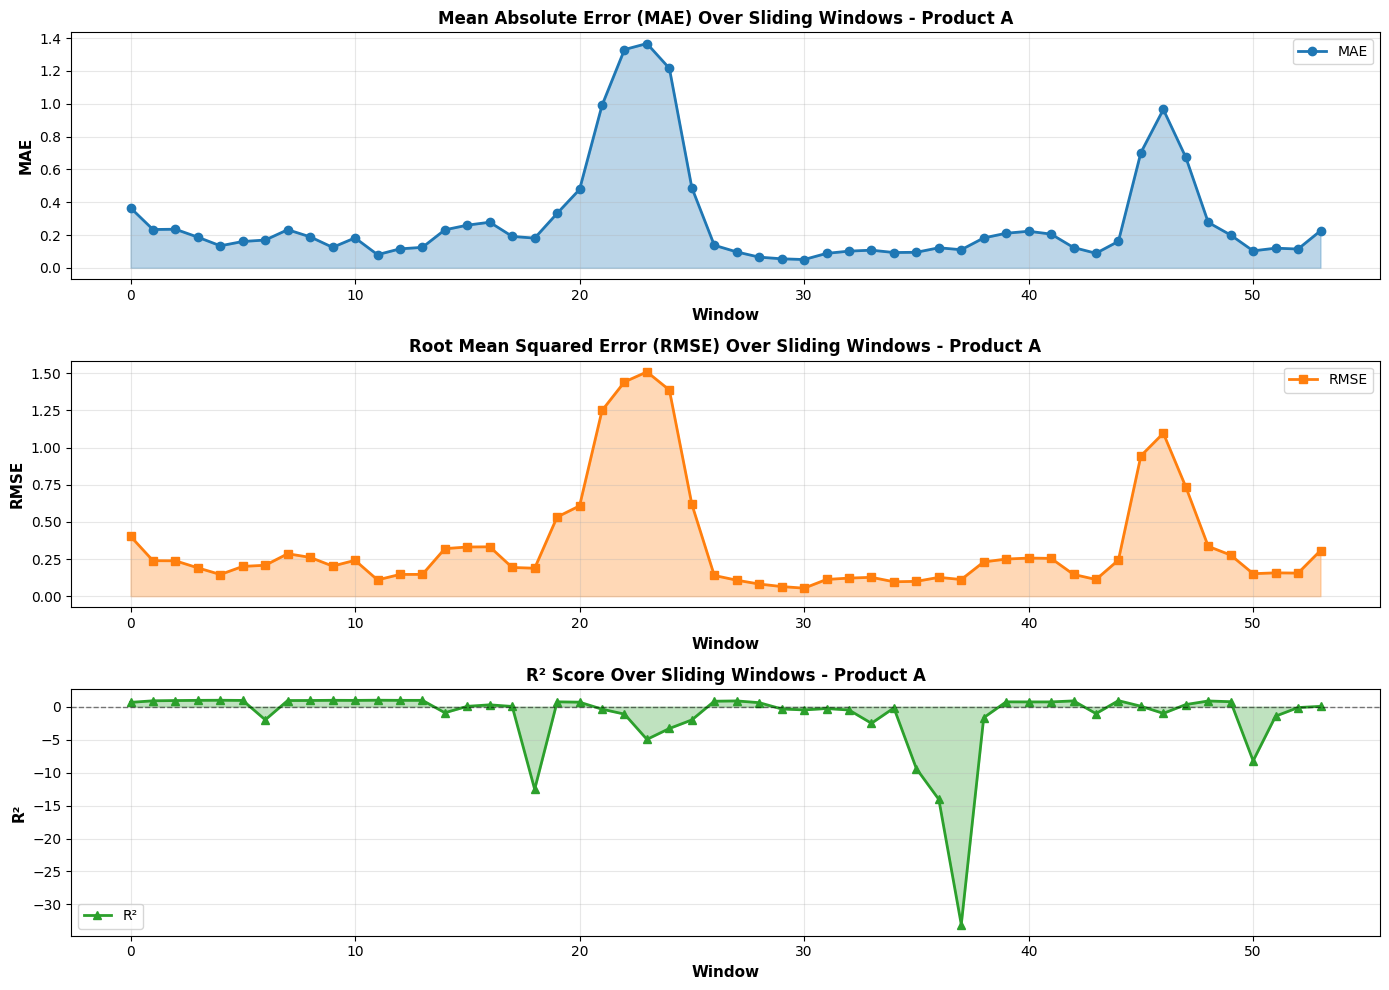


PERFORMANCE METRICS TREND ANALYSIS

MAE:
  Min: 0.0506, Max: 1.3668, Std: 0.3188

RMSE:
  Min: 0.0538, Max: 1.5090, Std: 0.3643

R²:
  Min: -33.0467, Max: 0.9789, Std: 5.4329

Average Coefficient: -3.2771
Average Intercept: 20.9438


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create visualizations
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: MAE over windows
axes[0].plot(results_df['Window'], results_df['MAE'], marker='o', linewidth=2, markersize=6, color='#1f77b4', label='MAE')
axes[0].fill_between(results_df['Window'], results_df['MAE'], alpha=0.3, color='#1f77b4')
axes[0].set_xlabel('Window', fontsize=11, fontweight='bold')
axes[0].set_ylabel('MAE', fontsize=11, fontweight='bold')
axes[0].set_title('Mean Absolute Error (MAE) Over Sliding Windows - Product A', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# Plot 2: RMSE over windows
axes[1].plot(results_df['Window'], results_df['RMSE'], marker='s', linewidth=2, markersize=6, color='#ff7f0e', label='RMSE')
axes[1].fill_between(results_df['Window'], results_df['RMSE'], alpha=0.3, color='#ff7f0e')
axes[1].set_xlabel('Window', fontsize=11, fontweight='bold')
axes[1].set_ylabel('RMSE', fontsize=11, fontweight='bold')
axes[1].set_title('Root Mean Squared Error (RMSE) Over Sliding Windows - Product A', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)

# Plot 3: R² over windows
axes[2].plot(results_df['Window'], results_df['R2'], marker='^', linewidth=2, markersize=6, color='#2ca02c', label='R²')
axes[2].fill_between(results_df['Window'], results_df['R2'], alpha=0.3, color='#2ca02c')
axes[2].set_xlabel('Window', fontsize=11, fontweight='bold')
axes[2].set_ylabel('R²', fontsize=11, fontweight='bold')
axes[2].set_title('R² Score Over Sliding Windows - Product A', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
axes[2].legend(fontsize=10)

plt.tight_layout()
plt.show()

# Print additional statistics
print("\n" + "="*100)
print("PERFORMANCE METRICS TREND ANALYSIS")
print("="*100)
print(f"\nMAE:")
print(f"  Min: {results_df['MAE'].min():.4f}, Max: {results_df['MAE'].max():.4f}, Std: {results_df['MAE'].std():.4f}")
print(f"\nRMSE:")
print(f"  Min: {results_df['RMSE'].min():.4f}, Max: {results_df['RMSE'].max():.4f}, Std: {results_df['RMSE'].std():.4f}")
print(f"\nR²:")
print(f"  Min: {results_df['R2'].min():.4f}, Max: {results_df['R2'].max():.4f}, Std: {results_df['R2'].std():.4f}")
print(f"\nAverage Coefficient: {results_df['Coef'].mean():.4f}")
print(f"Average Intercept: {results_df['Intercept'].mean():.4f}")

In [26]:
# data_weekly.columns
FEATURES_XGB = ['log_sell_price_A','log_running_week_A','month',
                'log_sell_price_B','log_sell_price_C',
                'log_sell_price_D','log_sell_price_E']
df_regression_A_XGB = data_weekly[FEATURES_XGB + [TARGET]]


In [27]:
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# SLIDING WINDOW XGBoost REGRESSION FOR PRODUCT A
# ============================================================================
# This cell implements XGBoost gradient boosting using the same sliding window
# cross-validation approach as OLS. XGBoost is a non-linear, ensemble method
# that can capture complex relationships between price and sales.

# Configuration parameters - same window sizes as OLS for fair comparison
train_window_weeks = 26  # Training window size in weeks
test_window_weeks = 4    # Test window size in weeks

results_xgb_list = []  # Store results from each window

# Sort data by index to ensure chronological order
df_sorted = df_regression_A_XGB.sort_index()
dates = sorted(df_sorted.index.unique())

# ============================================================================
# Sliding Window Loop - Creates multiple train-test splits
# ============================================================================
for i in range(len(dates) - train_window_weeks - test_window_weeks + 1):
    # Calculate indices for training window (fixed size of 26 weeks)
    train_start_idx = i
    train_end_idx = i + train_window_weeks - 1
    
    # Calculate indices for testing window (fixed size of 4 weeks, right after training)
    test_start_idx = train_end_idx + 1
    test_end_idx = min(test_start_idx + test_window_weeks - 1, len(dates) - 1)
    
    # Skip if test window is incomplete
    if test_end_idx - test_start_idx + 1 < test_window_weeks:
        continue
    
    # Convert indices to actual dates
    train_start_date = dates[train_start_idx]
    train_end_date = dates[train_end_idx]
    test_start_date = dates[test_start_idx]
    test_end_date = dates[test_end_idx]
    
    # Split data by date ranges
    df_train_window = df_sorted[(df_sorted.index >= train_start_date) & (df_sorted.index <= train_end_date)]
    df_test_window = df_sorted[(df_sorted.index >= test_start_date) & (df_sorted.index <= test_end_date)]
    
    # Skip if either window is empty
    if len(df_train_window) == 0 or len(df_test_window) == 0:
        continue
    
    # Skip if feature has no variance (cannot fit regression)
    if df_train_window[FEATURES_XGB[0]].std() == 0:
        continue
    
    # Extract features (X) and target (y) for this window
    # Note: Convert to numpy arrays for XGBoost compatibility (unlike OLS which uses DataFrames)
    X_train_w = df_train_window[FEATURES_XGB].values
    y_train_w = df_train_window[TARGET].values
    X_test_w = df_test_window[FEATURES_XGB].values
    y_test_w = df_test_window[TARGET].values
    
    try:
        # ====================================================================
        # XGBoost Regression Model
        # ====================================================================
        # Initialize XGBoost regressor with hyperparameters
        # - n_estimators: 100 boosting rounds (trees)
        # - learning_rate: 0.1 (shrinkage factor for gradual learning)
        # - max_depth: 4 (tree depth to prevent overfitting)
        # - random_state: 42 (for reproducibility)
        # - verbosity: 0 (suppress output during training)
        model_xgb = XGBRegressor(
            n_estimators=100, 
            learning_rate=0.1, 
            max_depth=4, 
            random_state=42, 
            verbosity=0
        )
        
        # Fit the model on training data
        # XGBoost builds an ensemble of decision trees iteratively
        model_xgb.fit(X_train_w, y_train_w)
        
        # Make predictions on test data
        y_pred = model_xgb.predict(X_test_w)
        
        # Calculate performance metrics
        mae = mean_absolute_error(y_test_w, y_pred)  # Mean Absolute Error
        rmse = np.sqrt(mean_squared_error(y_test_w, y_pred))  # Root Mean Squared Error
        r2 = r2_score(y_test_w, y_pred)  # R-squared (coefficient of determination)
        
        # Store results for this window
        results_xgb_list.append({
            'Window': len(results_xgb_list),  # Window number
            'Train_Start': train_start_date.date(),  # Training period start
            'Train_End': train_end_date.date(),  # Training period end
            'Test_Start': test_start_date.date(),  # Testing period start
            'Test_End': test_end_date.date(),  # Testing period end
            'Train_Size': len(df_train_window),  # Number of training samples
            'Test_Size': len(df_test_window),  # Number of test samples
            'MAE': mae,  # Mean Absolute Error
            'RMSE': rmse,  # Root Mean Squared Error
            'R2': r2  # R² Score
        })
        
        # Print progress every 5 windows or for the first window
        if len(results_xgb_list) == 1 or len(results_xgb_list) % 5 == 0:
            print(f"Window {len(results_xgb_list)}: Train ({train_start_date.date()} to {train_end_date.date()}) | "
                  f"Test ({test_start_date.date()} to {test_end_date.date()}) | "
                  f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    except Exception as e:
        # Skip windows with fitting errors (rare with XGBoost)
        continue

# ============================================================================
# Create Summary Results
# ============================================================================
if results_xgb_list:
    # Convert results to DataFrame for analysis and visualization
    results_xgb_df = pd.DataFrame(results_xgb_list)
    print("\n" + "="*100)
    print("SLIDING WINDOW XGBoost REGRESSION RESULTS FOR PRODUCT A")
    print("="*100)
    print(results_xgb_df.to_string(index=False))
    print("\nSummary Statistics:")
    print(f"Mean MAE: {results_xgb_df['MAE'].mean():.4f}")
    print(f"Mean RMSE: {results_xgb_df['RMSE'].mean():.4f}")
    print(f"Mean R²: {results_xgb_df['R2'].mean():.4f}")
    print(f"Total windows: {len(results_xgb_df)}")

else:
    print("No valid windows found. Check your data and window sizes.")


Window 1: Train (2019-01-06 to 2019-06-30) | Test (2019-07-07 to 2019-07-28) | MAE: 0.1671, RMSE: 0.2198, R²: 0.8966
Window 5: Train (2019-02-03 to 2019-07-28) | Test (2019-08-04 to 2019-08-25) | MAE: 0.2447, RMSE: 0.2504, R²: 0.9218
Window 10: Train (2019-03-10 to 2019-09-01) | Test (2019-09-08 to 2019-09-29) | MAE: 0.1164, RMSE: 0.1615, R²: -0.1704
Window 15: Train (2019-04-14 to 2019-10-06) | Test (2019-10-13 to 2019-11-03) | MAE: 0.1945, RMSE: 0.2263, R²: 0.9100
Window 20: Train (2019-05-19 to 2019-11-10) | Test (2019-11-17 to 2019-12-08) | MAE: 0.2022, RMSE: 0.2606, R²: -2.4110
Window 25: Train (2019-06-23 to 2019-12-15) | Test (2019-12-22 to 2020-01-12) | MAE: 0.4408, RMSE: 0.5207, R²: -1.3499
Window 30: Train (2019-07-28 to 2020-01-19) | Test (2020-01-26 to 2020-02-16) | MAE: 0.0536, RMSE: 0.0692, R²: -0.2168
Window 35: Train (2019-09-01 to 2020-02-23) | Test (2020-03-01 to 2020-03-22) | MAE: 0.7350, RMSE: 0.8726, R²: 0.2189
Window 40: Train (2019-10-06 to 2020-03-29) | Test (20

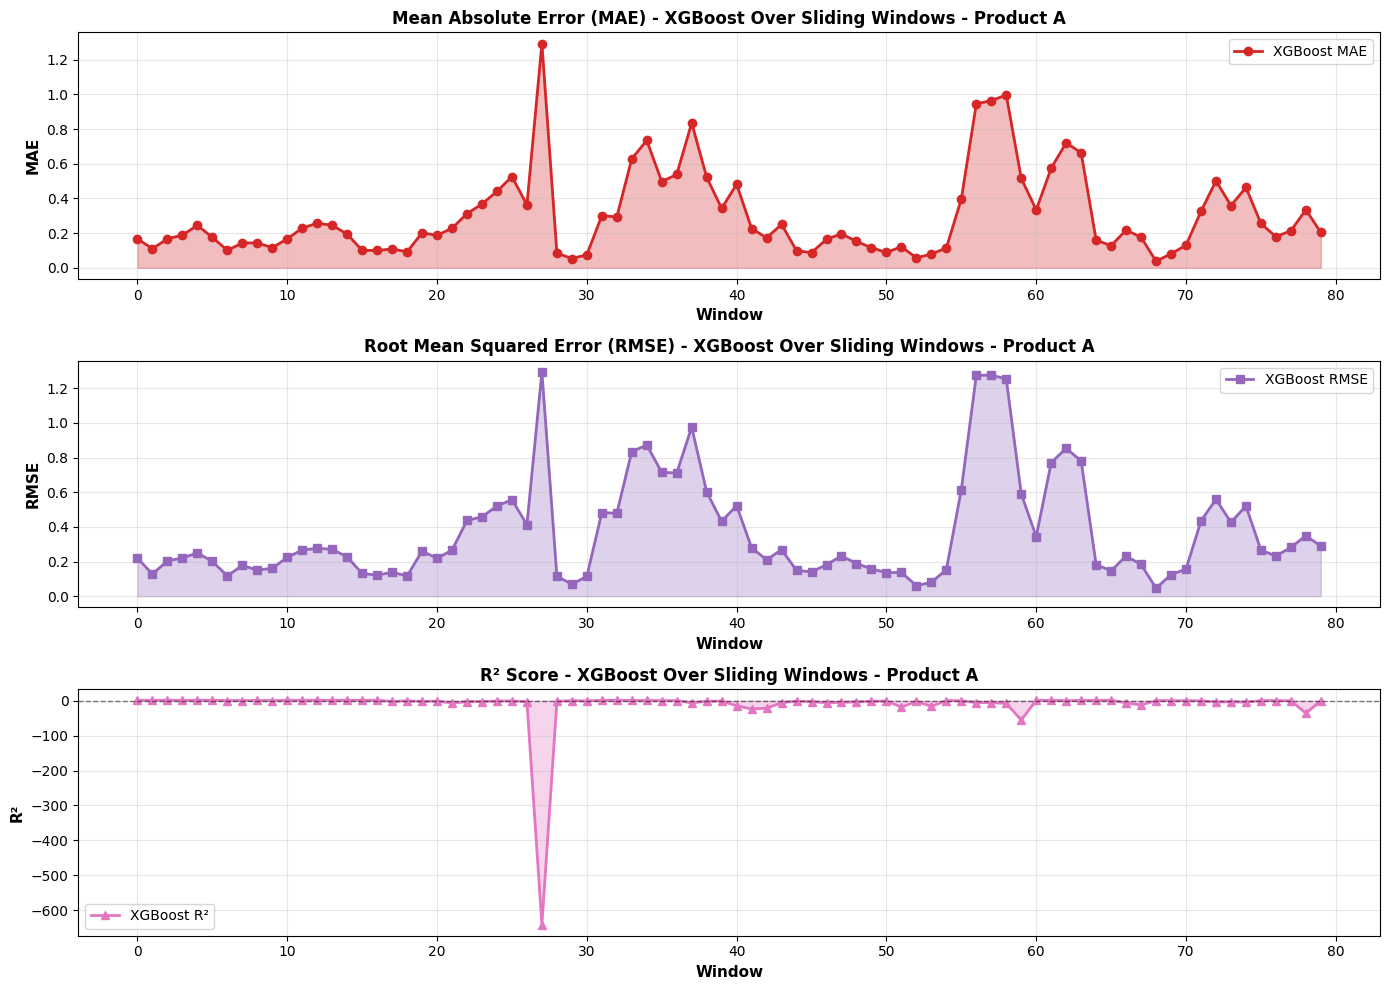


XGBOOST PERFORMANCE METRICS TREND ANALYSIS

MAE:
  Min: 0.0380, Max: 1.2935, Std: 0.2506

RMSE:
  Min: 0.0462, Max: 1.2948, Std: 0.3022

R²:
  Min: -640.2135, Max: 0.9708, Std: 71.6805


In [28]:
# Plot XGBoost results
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: MAE over windows
axes[0].plot(results_xgb_df['Window'], results_xgb_df['MAE'], marker='o', linewidth=2, markersize=6, color='#d62728', label='XGBoost MAE')
axes[0].fill_between(results_xgb_df['Window'], results_xgb_df['MAE'], alpha=0.3, color='#d62728')
axes[0].set_xlabel('Window', fontsize=11, fontweight='bold')
axes[0].set_ylabel('MAE', fontsize=11, fontweight='bold')
axes[0].set_title('Mean Absolute Error (MAE) - XGBoost Over Sliding Windows - Product A', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# Plot 2: RMSE over windows
axes[1].plot(results_xgb_df['Window'], results_xgb_df['RMSE'], marker='s', linewidth=2, markersize=6, color='#9467bd', label='XGBoost RMSE')
axes[1].fill_between(results_xgb_df['Window'], results_xgb_df['RMSE'], alpha=0.3, color='#9467bd')
axes[1].set_xlabel('Window', fontsize=11, fontweight='bold')
axes[1].set_ylabel('RMSE', fontsize=11, fontweight='bold')
axes[1].set_title('Root Mean Squared Error (RMSE) - XGBoost Over Sliding Windows - Product A', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)

# Plot 3: R² over windows
axes[2].plot(results_xgb_df['Window'], results_xgb_df['R2'], marker='^', linewidth=2, markersize=6, color='#e377c2', label='XGBoost R²')
axes[2].fill_between(results_xgb_df['Window'], results_xgb_df['R2'], alpha=0.3, color='#e377c2')
axes[2].set_xlabel('Window', fontsize=11, fontweight='bold')
axes[2].set_ylabel('R²', fontsize=11, fontweight='bold')
axes[2].set_title('R² Score - XGBoost Over Sliding Windows - Product A', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
axes[2].legend(fontsize=10)

plt.tight_layout()
plt.show()

# Print additional statistics
print("\n" + "="*100)
print("XGBOOST PERFORMANCE METRICS TREND ANALYSIS")
print("="*100)
print(f"\nMAE:")
print(f"  Min: {results_xgb_df['MAE'].min():.4f}, Max: {results_xgb_df['MAE'].max():.4f}, Std: {results_xgb_df['MAE'].std():.4f}")
print(f"\nRMSE:")
print(f"  Min: {results_xgb_df['RMSE'].min():.4f}, Max: {results_xgb_df['RMSE'].max():.4f}, Std: {results_xgb_df['RMSE'].std():.4f}")
print(f"\nR²:")
print(f"  Min: {results_xgb_df['R2'].min():.4f}, Max: {results_xgb_df['R2'].max():.4f}, Std: {results_xgb_df['R2'].std():.4f}")

In [8]:
from pygam import LinearGAM, ExpectileGAM
import warnings
warnings.filterwarnings('ignore')

# Sliding window train-test split with PyGAM Quantile Regression
train_window_weeks = 26  # Training window size in weeks
test_window_weeks = 4    # Test window size in weeks
quantiles = [0.025, 0.5, 0.975]  # Quantiles to estimate

results_pygam_dict = {q: [] for q in quantiles}

# Sort data by index
df_sorted = df_regression_A.sort_index()
dates = sorted(df_sorted.index.unique())

# Sliding window approach
for i in range(len(dates) - train_window_weeks - test_window_weeks + 1):
    # Training: fixed window of train_window_weeks
    train_start_idx = i
    train_end_idx = i + train_window_weeks - 1
    
    # Testing: next test_window_weeks after training
    test_start_idx = train_end_idx + 1
    test_end_idx = min(test_start_idx + test_window_weeks - 1, len(dates) - 1)
    
    if test_end_idx - test_start_idx + 1 < test_window_weeks:
        continue
    
    train_start_date = dates[train_start_idx]
    train_end_date = dates[train_end_idx]
    test_start_date = dates[test_start_idx]
    test_end_date = dates[test_end_idx]
    
    # Split data by dates
    df_train_window = df_sorted[(df_sorted.index >= train_start_date) & (df_sorted.index <= train_end_date)]
    df_test_window = df_sorted[(df_sorted.index >= test_start_date) & (df_sorted.index <= test_end_date)]
    
    if len(df_train_window) == 0 or len(df_test_window) == 0:
        continue
    
    # Check if feature has variance
    if df_train_window[FEATURES[0]].std() == 0:
        continue
    
    X_train_w = df_train_window[FEATURES].values
    y_train_w = df_train_window[TARGET].values
    X_test_w = df_test_window[FEATURES].values
    y_test_w = df_test_window[TARGET].values
    
    try:
        # PyGAM Quantile Regression (using ExpectileGAM as approximation for quantiles)
        for q in quantiles:
            try:
                model_pygam = ExpectileGAM(expectile=q)
                model_pygam.fit(X_train_w, y_train_w)
                y_pred = model_pygam.predict(X_test_w)
                
                # Calculate metrics
                mae = mean_absolute_error(y_test_w, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test_w, y_pred))
                r2 = r2_score(y_test_w, y_pred)
                
                results_pygam_dict[q].append({
                    'Window': len(results_pygam_dict[q]),
                    'Train_Start': train_start_date.date(),
                    'Train_End': train_end_date.date(),
                    'Test_Start': test_start_date.date(),
                    'Test_End': test_end_date.date(),
                    'Train_Size': len(df_train_window),
                    'Test_Size': len(df_test_window),
                    'MAE': mae,
                    'RMSE': rmse,
                    'R2': r2,
                    'Quantile': q
                })
            except:
                continue
        
        if len(results_pygam_dict[0.5]) == 1 or len(results_pygam_dict[0.5]) % 5 == 0:
            mae_025 = results_pygam_dict[0.025][-1]['MAE'] if results_pygam_dict[0.025] else np.nan
            mae_50 = results_pygam_dict[0.5][-1]['MAE'] if results_pygam_dict[0.5] else np.nan
            mae_975 = results_pygam_dict[0.975][-1]['MAE'] if results_pygam_dict[0.975] else np.nan
            print(f"Window {len(results_pygam_dict[0.5])}: Train ({train_start_date.date()} to {train_end_date.date()}) | "
                  f"Q[0.025]: {mae_025:.4f}, Q[0.5]: {mae_50:.4f}, Q[0.975]: {mae_975:.4f}")
    except Exception as e:
        continue

# Create results dataframes for each quantile
results_pygam_dfs = {}
for q in quantiles:
    if results_pygam_dict[q]:
        results_pygam_dfs[q] = pd.DataFrame(results_pygam_dict[q])
        print(f"\n{'='*100}")
        print(f"SLIDING WINDOW PyGAM QUANTILE REGRESSION (Q={q}) RESULTS FOR PRODUCT A")
        print(f"{'='*100}")
        print(results_pygam_dfs[q].to_string(index=False))
        print(f"\nSummary Statistics for Q={q}:")
        print(f"Mean MAE: {results_pygam_dfs[q]['MAE'].mean():.4f}")
        print(f"Mean RMSE: {results_pygam_dfs[q]['RMSE'].mean():.4f}")
        print(f"Mean R²: {results_pygam_dfs[q]['R2'].mean():.4f}")

Window 1: Train (2019-01-06 to 2019-06-30) | Q[0.025]: 0.5268, Q[0.5]: 0.2549, Q[0.975]: 0.1696
Window 5: Train (2019-02-03 to 2019-07-28) | Q[0.025]: 0.3643, Q[0.5]: 0.0846, Q[0.975]: 0.1510
Window 10: Train (2019-03-10 to 2019-09-01) | Q[0.025]: 0.3402, Q[0.5]: 0.1391, Q[0.975]: 0.1825
Window 15: Train (2019-04-14 to 2019-10-06) | Q[0.025]: 0.3036, Q[0.5]: 0.1209, Q[0.975]: 0.1765
Window 20: Train (2019-05-19 to 2019-11-10) | Q[0.025]: 0.1750, Q[0.5]: 0.1139, Q[0.975]: 0.1955
Window 25: Train (2019-06-23 to 2019-12-15) | Q[0.025]: 0.2196, Q[0.5]: 0.2604, Q[0.975]: 0.3785
Window 30: Train (2019-07-28 to 2020-01-19) | Q[0.025]: 0.2844, Q[0.5]: 0.0623, Q[0.975]: 0.0645
Window 35: Train (2019-09-01 to 2020-02-23) | Q[0.025]: 2.3015, Q[0.5]: 1.5190, Q[0.975]: 1.2130
Window 40: Train (2019-10-06 to 2020-03-29) | Q[0.025]: 0.4539, Q[0.5]: 0.3638, Q[0.975]: 0.4551
Window 45: Train (2019-11-10 to 2020-05-03) | Q[0.025]: 0.2769, Q[0.5]: 0.0823, Q[0.975]: 0.1201
Window 50: Train (2019-12-15 to 

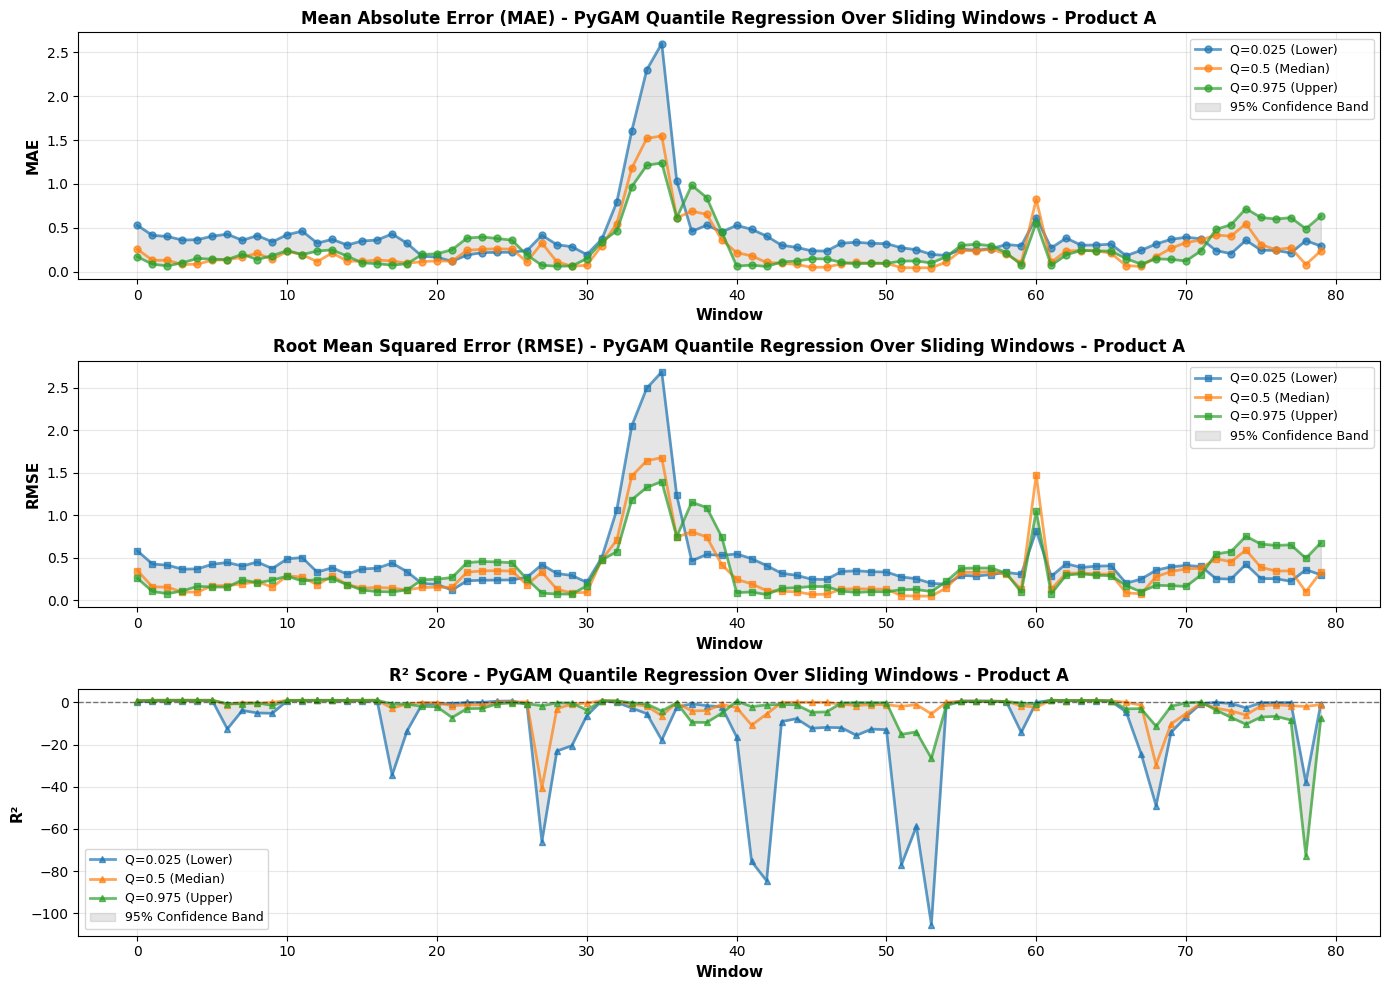


PyGAM QUANTILE REGRESSION - PERFORMANCE COMPARISON ACROSS QUANTILES

Quantile 0.025:
  MAE  - Min: 0.1171, Max: 2.6011, Mean: 0.4062
  RMSE - Min: 0.1184, Max: 2.6840, Mean: 0.4448
  R²   - Min: -105.3206, Max: 0.9177, Mean: -10.9725

Quantile 0.5:
  MAE  - Min: 0.0431, Max: 1.5474, Mean: 0.2541
  RMSE - Min: 0.0471, Max: 1.6758, Mean: 0.3167
  R²   - Min: -40.6318, Max: 0.9897, Mean: -1.9498

Quantile 0.975:
  MAE  - Min: 0.0587, Max: 1.2396, Mean: 0.2822
  RMSE - Min: 0.0655, Max: 1.3951, Mean: 0.3366
  R²   - Min: -72.6449, Max: 0.9940, Mean: -3.1894


In [9]:
# Plot PyGAM Quantile Regression results
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Colors for each quantile
quantile_labels = ['Q=0.025 (Lower)', 'Q=0.5 (Median)', 'Q=0.975 (Upper)']

# Plot 1: MAE over windows for all quantiles
for q, color, label in zip(quantiles, colors, quantile_labels):
    if q in results_pygam_dfs:
        axes[0].plot(results_pygam_dfs[q]['Window'], results_pygam_dfs[q]['MAE'], 
                    marker='o', linewidth=2, markersize=5, color=color, label=label, alpha=0.7)

axes[0].fill_between(range(len(results_pygam_dfs[0.5])), 
                      results_pygam_dfs[0.025]['MAE'].values, 
                      results_pygam_dfs[0.975]['MAE'].values, alpha=0.2, color='gray', label='95% Confidence Band')
axes[0].set_xlabel('Window', fontsize=11, fontweight='bold')
axes[0].set_ylabel('MAE', fontsize=11, fontweight='bold')
axes[0].set_title('Mean Absolute Error (MAE) - PyGAM Quantile Regression Over Sliding Windows - Product A', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=9, loc='best')

# Plot 2: RMSE over windows for all quantiles
for q, color, label in zip(quantiles, colors, quantile_labels):
    if q in results_pygam_dfs:
        axes[1].plot(results_pygam_dfs[q]['Window'], results_pygam_dfs[q]['RMSE'], 
                    marker='s', linewidth=2, markersize=5, color=color, label=label, alpha=0.7)

axes[1].fill_between(range(len(results_pygam_dfs[0.5])), 
                      results_pygam_dfs[0.025]['RMSE'].values, 
                      results_pygam_dfs[0.975]['RMSE'].values, alpha=0.2, color='gray', label='95% Confidence Band')
axes[1].set_xlabel('Window', fontsize=11, fontweight='bold')
axes[1].set_ylabel('RMSE', fontsize=11, fontweight='bold')
axes[1].set_title('Root Mean Squared Error (RMSE) - PyGAM Quantile Regression Over Sliding Windows - Product A', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=9, loc='best')

# Plot 3: R² over windows for all quantiles
for q, color, label in zip(quantiles, colors, quantile_labels):
    if q in results_pygam_dfs:
        axes[2].plot(results_pygam_dfs[q]['Window'], results_pygam_dfs[q]['R2'], 
                    marker='^', linewidth=2, markersize=5, color=color, label=label, alpha=0.7)

axes[2].fill_between(range(len(results_pygam_dfs[0.5])), 
                      results_pygam_dfs[0.025]['R2'].values, 
                      results_pygam_dfs[0.975]['R2'].values, alpha=0.2, color='gray', label='95% Confidence Band')
axes[2].set_xlabel('Window', fontsize=11, fontweight='bold')
axes[2].set_ylabel('R²', fontsize=11, fontweight='bold')
axes[2].set_title('R² Score - PyGAM Quantile Regression Over Sliding Windows - Product A', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
axes[2].legend(fontsize=9, loc='best')

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\n" + "="*100)
print("PyGAM QUANTILE REGRESSION - PERFORMANCE COMPARISON ACROSS QUANTILES")
print("="*100)
for q in quantiles:
    if q in results_pygam_dfs:
        print(f"\nQuantile {q}:")
        print(f"  MAE  - Min: {results_pygam_dfs[q]['MAE'].min():.4f}, Max: {results_pygam_dfs[q]['MAE'].max():.4f}, Mean: {results_pygam_dfs[q]['MAE'].mean():.4f}")
        print(f"  RMSE - Min: {results_pygam_dfs[q]['RMSE'].min():.4f}, Max: {results_pygam_dfs[q]['RMSE'].max():.4f}, Mean: {results_pygam_dfs[q]['RMSE'].mean():.4f}")
        print(f"  R²   - Min: {results_pygam_dfs[q]['R2'].min():.4f}, Max: {results_pygam_dfs[q]['R2'].max():.4f}, Mean: {results_pygam_dfs[q]['R2'].mean():.4f}")

# B

In [10]:
data_weekly_B

,log_sales_B,log_sell_price_B
date,,
2019-01-06,4.897840,3.616040
2019-01-13,5.568345,3.616040
2019-01-20,5.332719,3.616040
2019-01-27,5.472271,3.616040
2019-02-03,5.220356,3.616040
...,...,...
2021-01-03,6.371612,3.673512
2021-01-10,6.363028,3.673512
2021-01-17,6.354370,3.656873


In [11]:
# Product B - OLS Sliding Window
df_regression_B = data_weekly_B.copy(deep=True)
FEATURES_B = ['log_sell_price_B']
TARGET_B = 'log_sales_B'

results_B_list = []
df_sorted_B = df_regression_B.sort_index()
dates_B = sorted(df_sorted_B.index.unique())

for i in range(len(dates_B) - 26 - 4 + 1):
    train_start_idx = i
    train_end_idx = i + 26 - 1
    test_start_idx = train_end_idx + 1
    test_end_idx = min(test_start_idx + 4 - 1, len(dates_B) - 1)
    
    if test_end_idx - test_start_idx + 1 < 4:
        continue
    
    train_start_date = dates_B[train_start_idx]
    train_end_date = dates_B[train_end_idx]
    test_start_date = dates_B[test_start_idx]
    test_end_date = dates_B[test_end_idx]
    
    df_train_window = df_sorted_B[(df_sorted_B.index >= train_start_date) & (df_sorted_B.index <= train_end_date)]
    df_test_window = df_sorted_B[(df_sorted_B.index >= test_start_date) & (df_sorted_B.index <= test_end_date)]
    
    if len(df_train_window) == 0 or len(df_test_window) == 0 or df_train_window[FEATURES_B[0]].std() == 0:
        continue
    
    X_train_w = df_train_window[FEATURES_B]
    y_train_w = df_train_window[TARGET_B]
    X_test_w = df_test_window[FEATURES_B]
    y_test_w = df_test_window[TARGET_B]
    
    X_train_w_const = sm.add_constant(X_train_w)
    X_test_w_const = sm.add_constant(X_test_w)
    
    try:
        model = sm.OLS(y_train_w, X_train_w_const).fit()
        if len(model.params) != X_test_w_const.shape[1]:
            continue
        y_pred = model.predict(X_test_w_const)
        
        mae = mean_absolute_error(y_test_w, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_w, y_pred))
        r2 = r2_score(y_test_w, y_pred)
        
        results_B_list.append({
            'Window': len(results_B_list),
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'Coef': model.params[1],
            'Intercept': model.params[0]
        })
    except:
        continue

results_B_df = pd.DataFrame(results_B_list)
print("PRODUCT B - OLS Results:")
print(f"Mean MAE: {results_B_df['MAE'].mean():.4f}, Mean RMSE: {results_B_df['RMSE'].mean():.4f}, Mean R²: {results_B_df['R2'].mean():.4f}\n")

PRODUCT B - OLS Results:
Mean MAE: 0.3087, Mean RMSE: 0.3596, Mean R²: -2.8964



In [12]:
# ============================================================================
# SLIDING WINDOW XGBoost REGRESSION FOR PRODUCT B
# ============================================================================
# This cell implements XGBoost gradient boosting using the same sliding window
# cross-validation approach as OLS. XGBoost is a non-linear, ensemble method
# that can capture complex relationships between price and sales.
#
# Key Differences from OLS:
# - Non-linear relationships: XGBoost can model non-linear price elasticity
# - Ensemble learning: Uses 100 decision trees, each correcting previous errors
# - Robustness: More resistant to outliers and can capture interactions
# - Computational: Requires more computation but often yields better predictions

# Configuration parameters - same window sizes as OLS for fair comparison
train_window_weeks = 26  # Training window size: 26 weeks of historical data
test_window_weeks = 4    # Test window size: 4 weeks for validation

results_B_xgb_list = []  # Store results (MAE, RMSE, R²) from each window

# ============================================================================
# Sliding Window Loop - Creates multiple non-overlapping train-test splits
# ============================================================================
# Loop creates sequential windows:
# - Window 1: weeks 0-25 (train) → weeks 26-29 (test)
# - Window 2: weeks 1-26 (train) → weeks 27-30 (test)
# - Window 3: weeks 2-27 (train) → weeks 28-31 (test)
# ... continues until end of available data
#
# This approach simulates real forecasting: train on past data, predict future

for i in range(len(dates_B) - 26 - 4 + 1):
    # ========================================================================
    # CALCULATE WINDOW INDICES
    # ========================================================================
    # For each iteration i, we create a 26-week training window and 4-week
    # test window that doesn't overlap.
    
    train_start_idx = i                    # Training window starts at index i
    train_end_idx = i + 26 - 1            # Training window ends 26 weeks later
    
    # Testing window immediately follows training window
    test_start_idx = train_end_idx + 1     # Test starts right after training ends
    test_end_idx = min(test_start_idx + 4 - 1, len(dates_B) - 1)  # Test ends 4 weeks later
    
    # Skip this window if test period is incomplete (fewer than 4 weeks)
    if test_end_idx - test_start_idx + 1 < 4:
        continue
    
    # ========================================================================
    # CONVERT INDICES TO DATES AND FILTER DATA
    # ========================================================================
    # Convert the numeric indices to actual dates for date-based filtering
    
    train_start_date = dates_B[train_start_idx]   # Earliest date in training set
    train_end_date = dates_B[train_end_idx]       # Latest date in training set
    test_start_date = dates_B[test_start_idx]     # Earliest date in test set
    test_end_date = dates_B[test_end_idx]         # Latest date in test set
    
    # Filter dataframe to get rows within the training window (26 weeks)
    df_train_window = df_sorted_B[(df_sorted_B.index >= train_start_date) & (df_sorted_B.index <= train_end_date)]
    # Filter dataframe to get rows within the test window (4 weeks)
    df_test_window = df_sorted_B[(df_sorted_B.index >= test_start_date) & (df_sorted_B.index <= test_end_date)]
    
    # ========================================================================
    # DATA QUALITY CHECKS
    # ========================================================================
    # Skip windows with insufficient or problematic data
    
    # Check 1: Both windows must have observations
    # Check 2: Feature must have variance (can't fit regression if all values are identical)
    if len(df_train_window) == 0 or len(df_test_window) == 0 or df_train_window[FEATURES_B[0]].std() == 0:
        continue
    
    # ========================================================================
    # PREPARE FEATURES AND TARGETS
    # ========================================================================
    # Extract features (price) and target (sales) as numpy arrays
    # Note: XGBoost requires numpy arrays, not pandas DataFrames
    
    X_train_w = df_train_window[FEATURES_B].values  # Price data for training (26 weeks)
    y_train_w = df_train_window[TARGET_B].values    # Sales data for training (26 weeks)
    X_test_w = df_test_window[FEATURES_B].values    # Price data for testing (4 weeks)
    y_test_w = df_test_window[TARGET_B].values      # Sales data for testing (4 weeks)
    
    try:
        # ====================================================================
        # XGBoost REGRESSION MODEL
        # ====================================================================
        # Initialize XGBoost regressor with hyperparameters:
        # - n_estimators=100: Build ensemble of 100 decision trees
        #   * Each tree learns from residuals of previous trees
        #   * Gradual improvement through boosting
        # - learning_rate=0.1: Shrinkage factor (0.1 = 10% of each tree's prediction)
        #   * Lower learning rate → slower learning but more regularization
        #   * Prevents overfitting to training data
        # - max_depth=4: Maximum tree depth (controls model complexity)
        #   * Depth 4 allows moderate interaction terms
        #   * Prevents overfitting while capturing non-linearity
        # - random_state=42: Fixed random seed for reproducibility
        # - verbosity=0: Suppress training output
        
        model_xgb = XGBRegressor(
            n_estimators=100,      # 100 boosting rounds (trees in ensemble)
            learning_rate=0.1,     # 10% shrinkage on each tree's contribution
            max_depth=4,           # Each tree can be up to 4 levels deep
            random_state=42,       # Reproducible results
            verbosity=0            # No training messages
        )
        
        # ====================================================================
        # TRAINING: Fit XGBoost to training window data
        # ====================================================================
        # XGBoost builds trees iteratively:
        # 1. First tree learns main patterns in price-sales relationship
        # 2. Second tree learns from residuals (errors) of first tree
        # 3. Third through 100th trees progressively refine predictions
        # Result: Gradient-boosted ensemble captures complex elasticity patterns
        
        model_xgb.fit(X_train_w, y_train_w)
        
        # ====================================================================
        # PREDICTION: Forecast sales on test window using trained model
        # ====================================================================
        # Apply the 100-tree ensemble to test data to generate predictions
        # Each tree contributes (learning_rate * prediction) to final result
        
        y_pred = model_xgb.predict(X_test_w)
        
        # ====================================================================
        # PERFORMANCE METRICS: Evaluate on test window
        # ====================================================================
        # Calculate three metrics to assess model quality on unseen test data
        
        # MAE (Mean Absolute Error): Average magnitude of prediction errors
        # - Units: Same as sales (log-scale)
        # - Interpretation: On average, predictions are off by this amount
        # - Example: MAE=0.05 means ±5% error on average
        mae = mean_absolute_error(y_test_w, y_pred)
        
        # RMSE (Root Mean Squared Error): Penalizes large errors more heavily
        # - Units: Same as sales (log-scale)
        # - Interpretation: Typical prediction error (considering all errors)
        # - Sensitivity: Larger errors have disproportionately larger impact
        rmse = np.sqrt(mean_squared_error(y_test_w, y_pred))
        
        # R² (R-squared): Proportion of variance explained by model
        # - Range: -∞ to 1.0 (1.0 = perfect, 0.0 = baseline, <0 = worse than mean)
        # - Interpretation: If R²=0.80, model explains 80% of sales variation
        # - Benchmark: Compare across models to choose best performer
        r2 = r2_score(y_test_w, y_pred)
        
        # ====================================================================
        # STORE RESULTS
        # ====================================================================
        # Save metrics from this window for later analysis and visualization
        
        results_B_xgb_list.append({
            'Window': len(results_B_xgb_list),  # Window sequence number (0, 1, 2, ...)
            'MAE': mae,                         # Mean Absolute Error for this window
            'RMSE': rmse,                       # Root Mean Squared Error for this window
            'R2': r2                            # R² Score for this window
        })
    except:
        # Skip windows that encounter fitting errors (rarely occurs with XGBoost)
        continue

# ============================================================================
# CREATE SUMMARY RESULTS AND PRINT STATISTICS
# ============================================================================
# Convert list of results to DataFrame for easier analysis and visualization

results_B_xgb_df = pd.DataFrame(results_B_xgb_list)

print("PRODUCT B - XGBoost Results:")
print(f"Mean MAE: {results_B_xgb_df['MAE'].mean():.4f}, Mean RMSE: {results_B_xgb_df['RMSE'].mean():.4f}, Mean R²: {results_B_xgb_df['R2'].mean():.4f}\n")


PRODUCT B - XGBoost Results:
Mean MAE: 0.3496, Mean RMSE: 0.4255, Mean R²: -35.3987



In [13]:
# Product B - PyGAM Quantile Sliding Window
results_B_pygam_dict = {q: [] for q in quantiles}
for i in range(len(dates_B) - 26 - 4 + 1):
    train_start_idx = i
    train_end_idx = i + 26 - 1
    test_start_idx = train_end_idx + 1
    test_end_idx = min(test_start_idx + 4 - 1, len(dates_B) - 1)
    
    if test_end_idx - test_start_idx + 1 < 4:
        continue
    
    train_start_date = dates_B[train_start_idx]
    train_end_date = dates_B[train_end_idx]
    test_start_date = dates_B[test_start_idx]
    test_end_date = dates_B[test_end_idx]
    
    df_train_window = df_sorted_B[(df_sorted_B.index >= train_start_date) & (df_sorted_B.index <= train_end_date)]
    df_test_window = df_sorted_B[(df_sorted_B.index >= test_start_date) & (df_sorted_B.index <= test_end_date)]
    
    if len(df_train_window) == 0 or len(df_test_window) == 0 or df_train_window[FEATURES_B[0]].std() == 0:
        continue
    
    X_train_w = df_train_window[FEATURES_B].values
    y_train_w = df_train_window[TARGET_B].values
    X_test_w = df_test_window[FEATURES_B].values
    y_test_w = df_test_window[TARGET_B].values
    
    for q in quantiles:
        try:
            model_pygam = ExpectileGAM(expectile=q)
            model_pygam.fit(X_train_w, y_train_w)
            y_pred = model_pygam.predict(X_test_w)
            
            mae = mean_absolute_error(y_test_w, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test_w, y_pred))
            r2 = r2_score(y_test_w, y_pred)
            
            results_B_pygam_dict[q].append({'Window': len(results_B_pygam_dict[q]), 'MAE': mae, 'RMSE': rmse, 'R2': r2})
        except:
            continue

results_B_pygam_dfs = {q: pd.DataFrame(results_B_pygam_dict[q]) for q in quantiles if results_B_pygam_dict[q]}
print("PRODUCT B - PyGAM Results:")
for q in quantiles:
    if q in results_B_pygam_dfs:
        print(f"  Q={q}: Mean MAE: {results_B_pygam_dfs[q]['MAE'].mean():.4f}, Mean RMSE: {results_B_pygam_dfs[q]['RMSE'].mean():.4f}, Mean R²: {results_B_pygam_dfs[q]['R2'].mean():.4f}")
print()

PRODUCT B - PyGAM Results:
  Q=0.025: Mean MAE: 0.4696, Mean RMSE: 0.5010, Mean R²: -55.2790
  Q=0.5: Mean MAE: 0.2857, Mean RMSE: 0.3233, Mean R²: -2.8036
  Q=0.975: Mean MAE: 0.3919, Mean RMSE: 0.4327, Mean R²: -51.9315



# C

In [14]:
# Product C - OLS, XGBoost, and PyGAM Sliding Window
df_regression_C = data_weekly_C.copy(deep=True)
FEATURES_C = ['log_sell_price_C']
TARGET_C = 'log_sales_C'

results_C_list = []
results_C_xgb_list = []
results_C_pygam_dict = {q: [] for q in quantiles}

df_sorted_C = df_regression_C.sort_index()
dates_C = sorted(df_sorted_C.index.unique())

for i in range(len(dates_C) - 26 - 4 + 1):
    train_start_idx = i
    train_end_idx = i + 26 - 1
    test_start_idx = train_end_idx + 1
    test_end_idx = min(test_start_idx + 4 - 1, len(dates_C) - 1)
    
    if test_end_idx - test_start_idx + 1 < 4:
        continue
    
    train_start_date = dates_C[train_start_idx]
    train_end_date = dates_C[train_end_idx]
    test_start_date = dates_C[test_start_idx]
    test_end_date = dates_C[test_end_idx]
    
    df_train_window = df_sorted_C[(df_sorted_C.index >= train_start_date) & (df_sorted_C.index <= train_end_date)]
    df_test_window = df_sorted_C[(df_sorted_C.index >= test_start_date) & (df_sorted_C.index <= test_end_date)]
    
    if len(df_train_window) == 0 or len(df_test_window) == 0 or df_train_window[FEATURES_C[0]].std() == 0:
        continue
    
    X_train_w = df_train_window[FEATURES_C]
    y_train_w = df_train_window[TARGET_C]
    X_test_w = df_test_window[FEATURES_C]
    y_test_w = df_test_window[TARGET_C]
    
    # OLS
    X_train_w_const = sm.add_constant(X_train_w)
    X_test_w_const = sm.add_constant(X_test_w)
    try:
        model = sm.OLS(y_train_w, X_train_w_const).fit()
        if len(model.params) == X_test_w_const.shape[1]:
            y_pred = model.predict(X_test_w_const)
            results_C_list.append({
                'Window': len(results_C_list),
                'MAE': mean_absolute_error(y_test_w, y_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test_w, y_pred)),
                'R2': r2_score(y_test_w, y_pred),
                'Coef': model.params[1],
                'Intercept': model.params[0]
            })
    except: pass
    
    # XGBoost
    X_train_w_arr = df_train_window[FEATURES_C].values
    y_train_w_arr = df_train_window[TARGET_C].values
    X_test_w_arr = df_test_window[FEATURES_C].values
    y_test_w_arr = df_test_window[TARGET_C].values
    
    try:
        model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42, verbosity=0)
        model_xgb.fit(X_train_w_arr, y_train_w_arr)
        y_pred = model_xgb.predict(X_test_w_arr)
        results_C_xgb_list.append({
            'Window': len(results_C_xgb_list),
            'MAE': mean_absolute_error(y_test_w_arr, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test_w_arr, y_pred)),
            'R2': r2_score(y_test_w_arr, y_pred)
        })
    except: pass
    
    # PyGAM
    for q in quantiles:
        try:
            model_pygam = ExpectileGAM(expectile=q)
            model_pygam.fit(X_train_w_arr, y_train_w_arr)
            y_pred = model_pygam.predict(X_test_w_arr)
            results_C_pygam_dict[q].append({
                'Window': len(results_C_pygam_dict[q]),
                'MAE': mean_absolute_error(y_test_w_arr, y_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test_w_arr, y_pred)),
                'R2': r2_score(y_test_w_arr, y_pred)
            })
        except: pass

results_C_df = pd.DataFrame(results_C_list)
results_C_xgb_df = pd.DataFrame(results_C_xgb_list)
results_C_pygam_dfs = {q: pd.DataFrame(results_C_pygam_dict[q]) for q in quantiles if results_C_pygam_dict[q]}

print("PRODUCT C - OLS Results:")
print(f"Mean MAE: {results_C_df['MAE'].mean():.4f}, Mean RMSE: {results_C_df['RMSE'].mean():.4f}, Mean R²: {results_C_df['R2'].mean():.4f}\n")
print("PRODUCT C - XGBoost Results:")
print(f"Mean MAE: {results_C_xgb_df['MAE'].mean():.4f}, Mean RMSE: {results_C_xgb_df['RMSE'].mean():.4f}, Mean R²: {results_C_xgb_df['R2'].mean():.4f}\n")
print("PRODUCT C - PyGAM Results:")
for q in quantiles:
    if q in results_C_pygam_dfs:
        print(f"  Q={q}: Mean MAE: {results_C_pygam_dfs[q]['MAE'].mean():.4f}, Mean RMSE: {results_C_pygam_dfs[q]['RMSE'].mean():.4f}, Mean R²: {results_C_pygam_dfs[q]['R2'].mean():.4f}")
print()

PRODUCT C - OLS Results:
Mean MAE: 0.5997, Mean RMSE: 0.6435, Mean R²: -110.7639

PRODUCT C - XGBoost Results:
Mean MAE: 0.6133, Mean RMSE: 0.6768, Mean R²: -78.6661

PRODUCT C - PyGAM Results:
  Q=0.025: Mean MAE: 0.8034, Mean RMSE: 0.8432, Mean R²: -225.0431
  Q=0.5: Mean MAE: 0.5735, Mean RMSE: 0.6121, Mean R²: -124.6767
  Q=0.975: Mean MAE: 0.4126, Mean RMSE: 0.4578, Mean R²: -27.4274



# E

In [15]:
data_weekly_E

,log_sales_E,log_running_week
date,,
2019-04-14,5.236442,2.708050
2019-04-21,5.733341,2.772589
2019-04-28,6.248043,2.833213
2019-05-05,6.111467,2.890372
2019-05-12,6.202536,2.944439
...,...,...
2021-01-03,7.032624,4.653960
2021-01-10,7.577122,4.663439
2021-01-17,7.301148,4.672829


In [16]:
# Product E - OLS, XGBoost, and PyGAM Sliding Window
df_regression_E = data_weekly_E.copy(deep=True)
FEATURES_E = ['log_running_week']
TARGET_E = 'log_sales_E'

results_E_list = []
results_E_xgb_list = []
results_E_pygam_dict = {q: [] for q in quantiles}

df_sorted_E = df_regression_E.sort_index()
dates_E = sorted(df_sorted_E.index.unique())

for i in range(len(dates_E) - 26 - 4 + 1):
    train_start_idx = i
    train_end_idx = i + 26 - 1
    test_start_idx = train_end_idx + 1
    test_end_idx = min(test_start_idx + 4 - 1, len(dates_E) - 1)
    
    if test_end_idx - test_start_idx + 1 < 4:
        continue
    
    train_start_date = dates_E[train_start_idx]
    train_end_date = dates_E[train_end_idx]
    test_start_date = dates_E[test_start_idx]
    test_end_date = dates_E[test_end_idx]
    
    df_train_window = df_sorted_E[(df_sorted_E.index >= train_start_date) & (df_sorted_E.index <= train_end_date)]
    df_test_window = df_sorted_E[(df_sorted_E.index >= test_start_date) & (df_sorted_E.index <= test_end_date)]
    
    if len(df_train_window) == 0 or len(df_test_window) == 0 or df_train_window[FEATURES_E[0]].std() == 0:
        continue
    
    X_train_w = df_train_window[FEATURES_E]
    y_train_w = df_train_window[TARGET_E]
    X_test_w = df_test_window[FEATURES_E]
    y_test_w = df_test_window[TARGET_E]
    
    # OLS
    X_train_w_const = sm.add_constant(X_train_w)
    X_test_w_const = sm.add_constant(X_test_w)
    try:
        model = sm.OLS(y_train_w, X_train_w_const).fit()
        if len(model.params) == X_test_w_const.shape[1]:
            y_pred = model.predict(X_test_w_const)
            results_E_list.append({
                'Window': len(results_E_list),
                'MAE': mean_absolute_error(y_test_w, y_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test_w, y_pred)),
                'R2': r2_score(y_test_w, y_pred),
                'Coef': model.params[1],
                'Intercept': model.params[0]
            })
    except: pass
    
    # XGBoost
    X_train_w_arr = df_train_window[FEATURES_E].values
    y_train_w_arr = df_train_window[TARGET_E].values
    X_test_w_arr = df_test_window[FEATURES_E].values
    y_test_w_arr = df_test_window[TARGET_E].values
    
    try:
        model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42, verbosity=0)
        model_xgb.fit(X_train_w_arr, y_train_w_arr)
        y_pred = model_xgb.predict(X_test_w_arr)
        results_E_xgb_list.append({
            'Window': len(results_E_xgb_list),
            'MAE': mean_absolute_error(y_test_w_arr, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test_w_arr, y_pred)),
            'R2': r2_score(y_test_w_arr, y_pred)
        })
    except: pass
    
    # PyGAM
    for q in quantiles:
        try:
            model_pygam = ExpectileGAM(expectile=q)
            model_pygam.fit(X_train_w_arr, y_train_w_arr)
            y_pred = model_pygam.predict(X_test_w_arr)
            results_E_pygam_dict[q].append({
                'Window': len(results_E_pygam_dict[q]),
                'MAE': mean_absolute_error(y_test_w_arr, y_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test_w_arr, y_pred)),
                'R2': r2_score(y_test_w_arr, y_pred)
            })
        except: pass

results_E_df = pd.DataFrame(results_E_list)
results_E_xgb_df = pd.DataFrame(results_E_xgb_list)
results_E_pygam_dfs = {q: pd.DataFrame(results_E_pygam_dict[q]) for q in quantiles if results_E_pygam_dict[q]}

print("PRODUCT E - OLS Results:")
print(f"Mean MAE: {results_E_df['MAE'].mean():.4f}, Mean RMSE: {results_E_df['RMSE'].mean():.4f}, Mean R²: {results_E_df['R2'].mean():.4f}\n")
print("PRODUCT E - XGBoost Results:")
print(f"Mean MAE: {results_E_xgb_df['MAE'].mean():.4f}, Mean RMSE: {results_E_xgb_df['RMSE'].mean():.4f}, Mean R²: {results_E_xgb_df['R2'].mean():.4f}\n")
print("PRODUCT E - PyGAM Results:")
for q in quantiles:
    if q in results_E_pygam_dfs:
        print(f"  Q={q}: Mean MAE: {results_E_pygam_dfs[q]['MAE'].mean():.4f}, Mean RMSE: {results_E_pygam_dfs[q]['RMSE'].mean():.4f}, Mean R²: {results_E_pygam_dfs[q]['R2'].mean():.4f}")

PRODUCT E - OLS Results:
Mean MAE: 0.2492, Mean RMSE: 0.2864, Mean R²: -12.1115

PRODUCT E - XGBoost Results:
Mean MAE: 0.2093, Mean RMSE: 0.2451, Mean R²: -5.2725

PRODUCT E - PyGAM Results:
  Q=0.025: Mean MAE: 0.3189, Mean RMSE: 0.3503, Mean R²: -15.9916
  Q=0.5: Mean MAE: 0.2447, Mean RMSE: 0.2863, Mean R²: -7.4192
  Q=0.975: Mean MAE: 0.2351, Mean RMSE: 0.2722, Mean R²: -5.9538


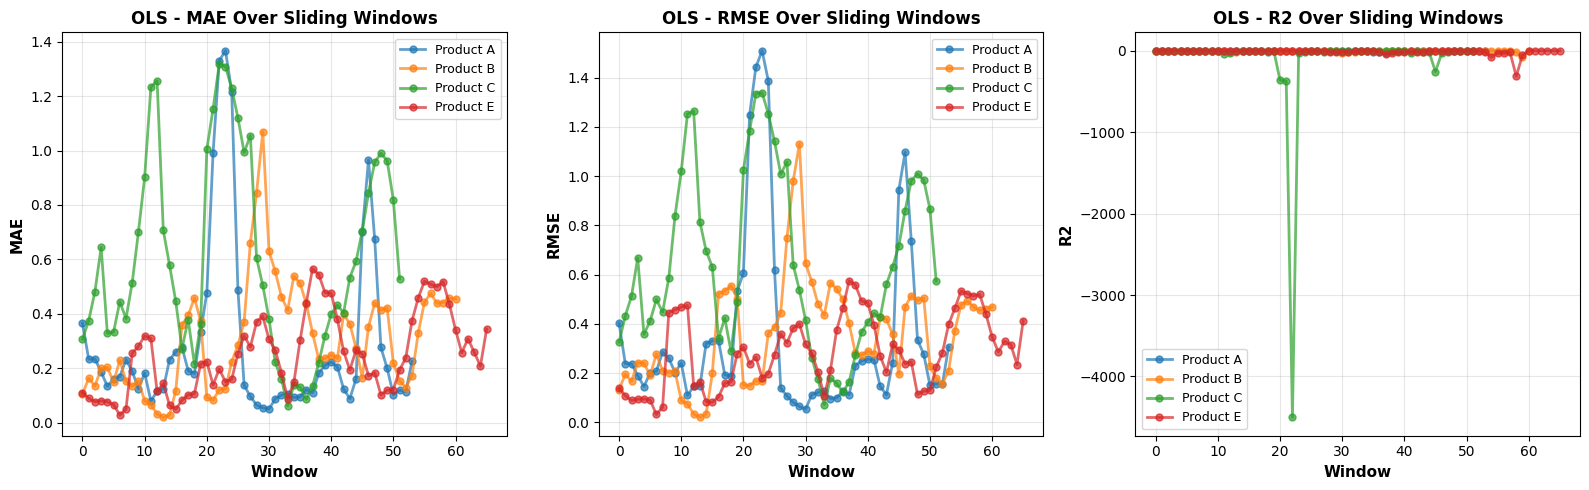

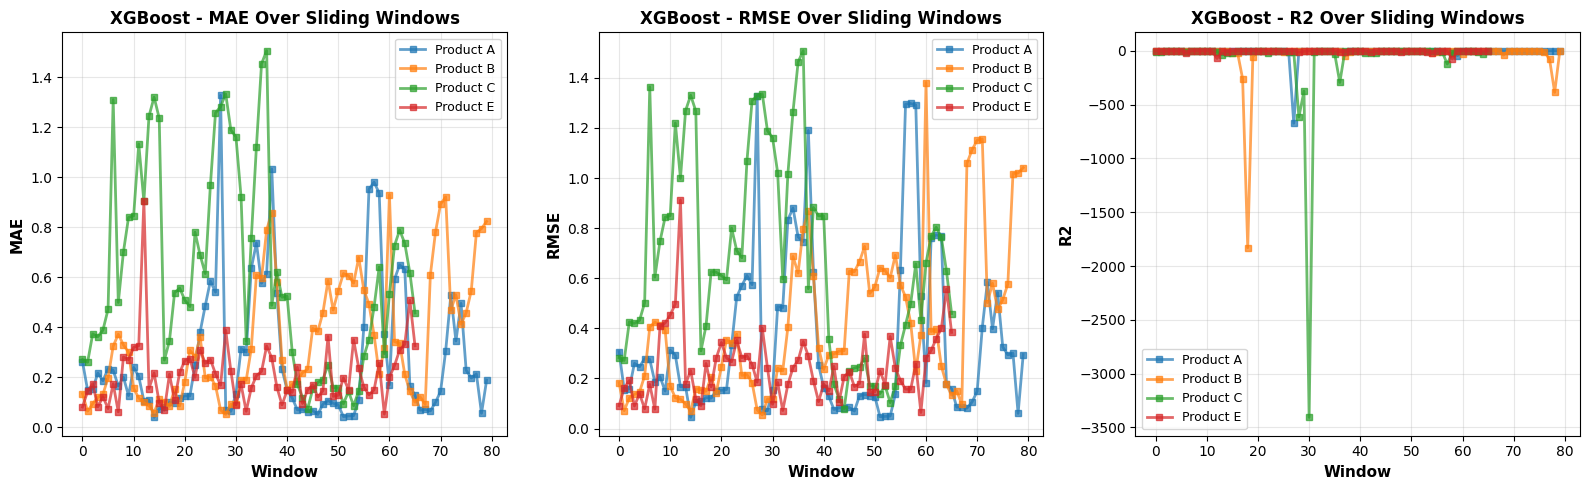


SUMMARY - ALL PRODUCTS AND MODELS
Product         Model  Mean_MAE  Mean_RMSE     Mean_R2
      A           OLS  0.288555   0.344832   -1.471984
      A       XGBoost  0.278762   0.346386  -10.058416
      A PyGAM (Q=0.5)  0.254099   0.316690   -1.949834
      B           OLS  0.308662   0.359625   -2.896426
      B       XGBoost  0.349577   0.425461  -35.398733
      B PyGAM (Q=0.5)  0.285707   0.323307   -2.803599
      C           OLS  0.599651   0.643508 -110.763875
      C       XGBoost  0.613339   0.676796  -78.666116
      C PyGAM (Q=0.5)  0.573484   0.612080 -124.676736
      E           OLS  0.249247   0.286407  -12.111488
      E       XGBoost  0.209270   0.245094   -5.272508
      E PyGAM (Q=0.5)  0.244692   0.286306   -7.419220


In [17]:
# Comparison across all products - OLS
products = ['A', 'B', 'C', 'E']
dfs_ols = [results_df, results_B_df, results_C_df, results_E_df]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Filter out empty dataframes
valid_products_ols = [(p, df, c) for p, df, c in zip(products, dfs_ols, colors) if len(df) > 0]

if valid_products_ols:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    for idx, metric in enumerate(['MAE', 'RMSE', 'R2']):
        for product, df_prod, color in valid_products_ols:
            axes[idx].plot(df_prod['Window'], df_prod[metric], marker='o', linewidth=2, markersize=5, 
                          color=color, label=f'Product {product}', alpha=0.7)
        axes[idx].set_xlabel('Window', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel(metric, fontsize=11, fontweight='bold')
        axes[idx].set_title(f'OLS - {metric} Over Sliding Windows', fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("No valid OLS data to plot")

# Comparison across all products - XGBoost
dfs_xgb = [results_xgb_df, results_B_xgb_df, results_C_xgb_df, results_E_xgb_df]

valid_products_xgb = [(p, df, c) for p, df, c in zip(products, dfs_xgb, colors) if len(df) > 0]

if valid_products_xgb:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    for idx, metric in enumerate(['MAE', 'RMSE', 'R2']):
        for product, df_prod, color in valid_products_xgb:
            axes[idx].plot(df_prod['Window'], df_prod[metric], marker='s', linewidth=2, markersize=5, 
                          color=color, label=f'Product {product}', alpha=0.7)
        axes[idx].set_xlabel('Window', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel(metric, fontsize=11, fontweight='bold')
        axes[idx].set_title(f'XGBoost - {metric} Over Sliding Windows', fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("No valid XGBoost data to plot")

# Summary comparison table
print("\n" + "="*120)
print("SUMMARY - ALL PRODUCTS AND MODELS")
print("="*120)
summary_data = []

# Collect PyGAM dataframes for each product
pygam_dfs_list = [results_pygam_dfs, results_B_pygam_dfs, results_C_pygam_dfs, results_E_pygam_dfs]

for product, df_ols, df_xgb, pygam_dfs in zip(products, dfs_ols, dfs_xgb, pygam_dfs_list):
    if len(df_ols) > 0:
        summary_data.append({
            'Product': product,
            'Model': 'OLS',
            'Mean_MAE': df_ols['MAE'].mean(),
            'Mean_RMSE': df_ols['RMSE'].mean(),
            'Mean_R2': df_ols['R2'].mean()
        })
    if len(df_xgb) > 0:
        summary_data.append({
            'Product': product,
            'Model': 'XGBoost',
            'Mean_MAE': df_xgb['MAE'].mean(),
            'Mean_RMSE': df_xgb['RMSE'].mean(),
            'Mean_R2': df_xgb['R2'].mean()
        })
    # Add PyGAM median (Q=0.5) to summary
    if 0.5 in pygam_dfs and len(pygam_dfs[0.5]) > 0:
        summary_data.append({
            'Product': product,
            'Model': 'PyGAM (Q=0.5)',
            'Mean_MAE': pygam_dfs[0.5]['MAE'].mean(),
            'Mean_RMSE': pygam_dfs[0.5]['RMSE'].mean(),
            'Mean_R2': pygam_dfs[0.5]['R2'].mean()
        })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
else:
    print("No valid data to summarize")